Initial shape: (768, 9)
After removing outliers: (515, 9)
Selected Features: ['Glucose', 'BMI', 'Age']

Performance Summary:



,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.743590,0.705882,0.444444,0.545455
1,Naive Bayes,0.730769,0.636364,0.518519,0.571429
2,SVM,0.756410,0.722222,0.481481,0.577778
3,Decision Tree,0.615385,0.454545,0.555556,0.500000
4,Random Forest,0.743590,0.640000,0.592593,0.615385
5,KNN,0.692308,0.551724,0.592593,0.571429
6,AdaBoost,0.743590,0.684211,0.481481,0.565217


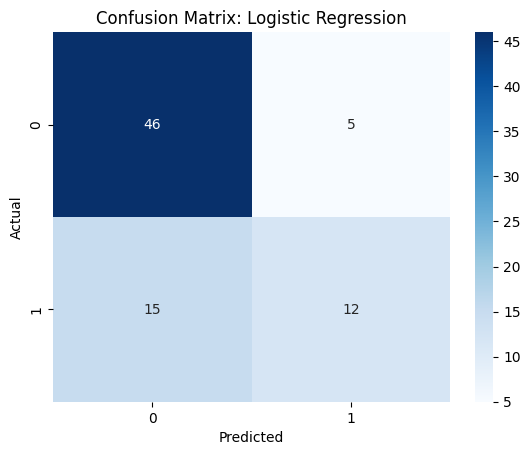

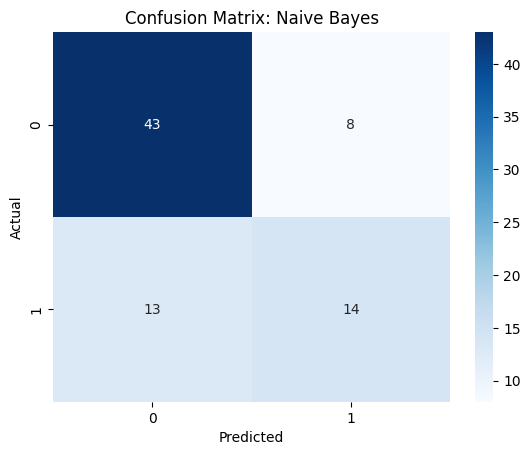

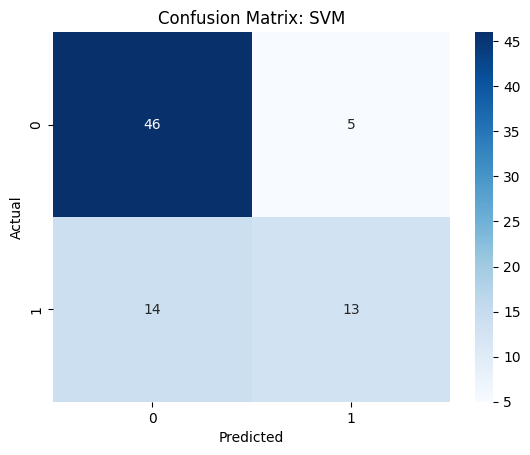

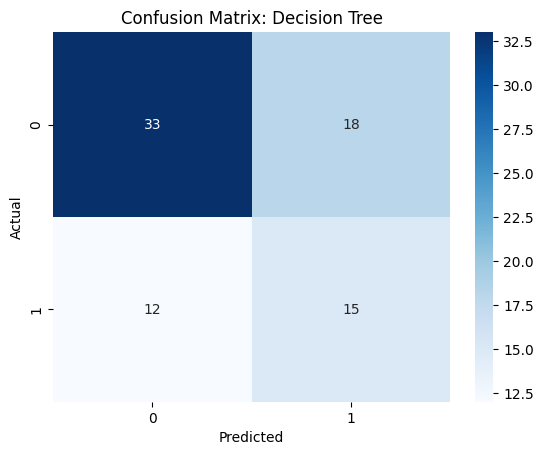

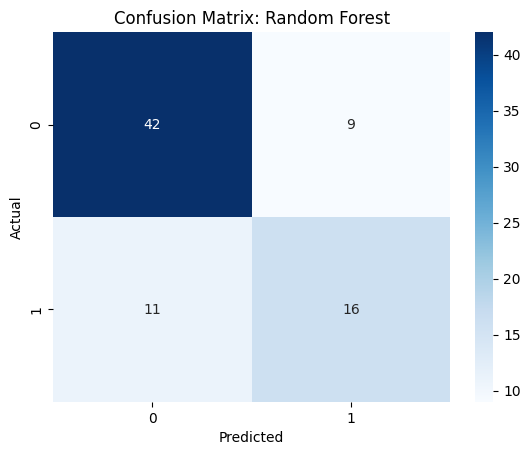

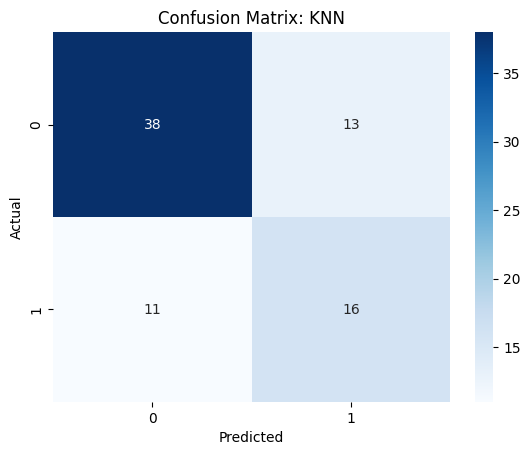

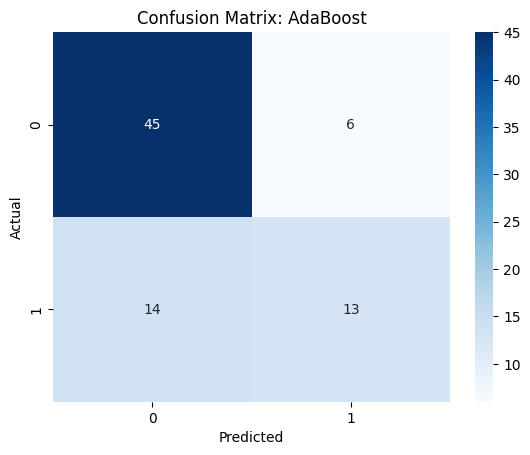

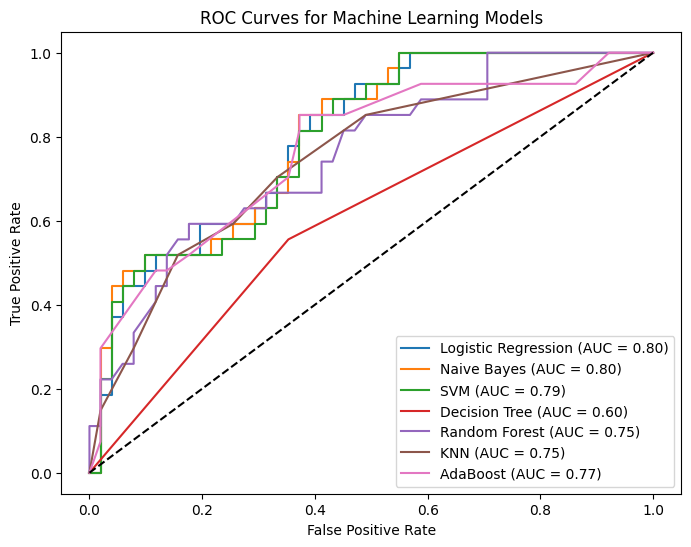

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Neural Network Accuracy: 74.36%


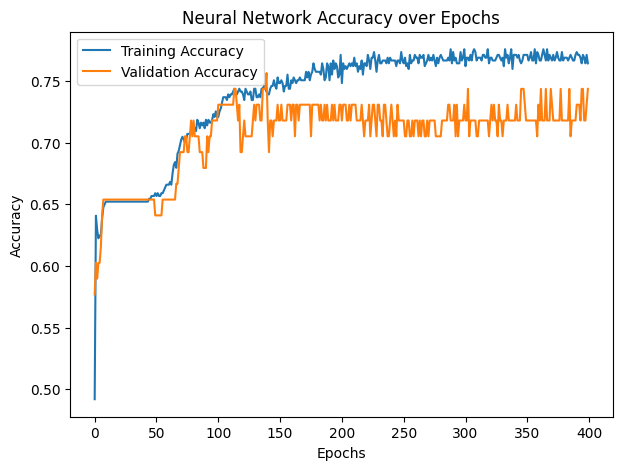

/tmp/ipython-input-2286976210.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="crest")


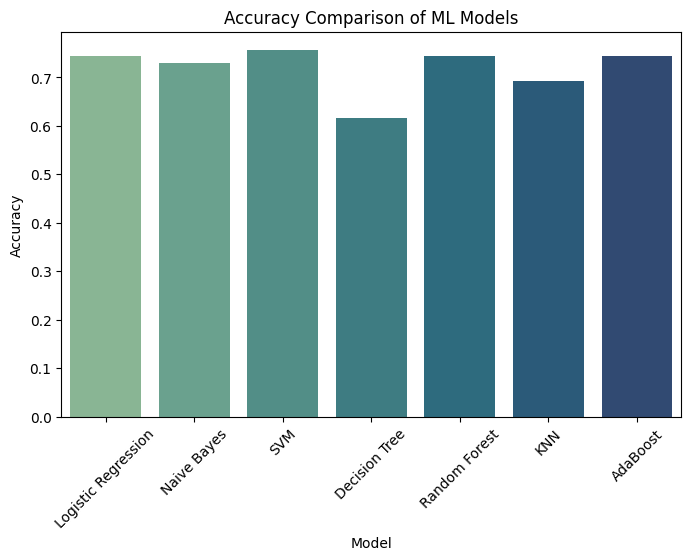

In [ ]:
# A Comparison of Machine Learning Algorithms for Diabetes Prediction

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

#  2. Load Dataset (Pima Indians Diabetes)
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DPF","Age","Outcome"]
data = pd.read_csv(url, names=cols)

print("Initial shape:", data.shape)
data.head()

# 3. Handle Missing Values (replace 0s with mean)
zero_cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
data[zero_cols] = data[zero_cols].replace(0, np.nan)
data.fillna(data.mean(), inplace=True)

# 4. Outlier Removal (IQR Method)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print("After removing outliers:", data.shape)

#  5. Feature Selection using Pearson Correlation (>0.2)
corr = data.corr()['Outcome'].abs().sort_values(ascending=False)
selected_features = corr[corr > 0.2].index.tolist()
selected_features.remove('Outcome')
print("Selected Features:", selected_features)

# 6. Normalization (0-1 scaling)
X = data[selected_features]
y = data['Outcome']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 7. Train-Test Split (85/15)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)

#  8. Train & Evaluate ML Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "AdaBoost": AdaBoostClassifier()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

# 9. Results Summary
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nPerformance Summary:\n")
display(results_df)

# 10. Confusion Matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 11. ROC Curves for All ML Models
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Machine Learning Models')
plt.legend()
plt.show()

# 2. Neural Network (2 Hidden Layers, 400 Epochs)
model_nn = Sequential([
    Dense(5, input_dim=len(selected_features), activation='relu'),
    Dense(26, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

opt = SGD(learning_rate=0.01)
model_nn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, validation_data=(X_test, y_test),
                       epochs=400, verbose=0)

# 13. NN Performance
loss, acc = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"\nNeural Network Accuracy: {acc*100:.2f}%")

# 14. Training vs Validation Accuracy Plot
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Neural Network Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 15. Bar Chart Comparison
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="crest")
plt.title("Accuracy Comparison of ML Models")
plt.xticks(rotation=45)
plt.show()


 Looking for Kaggle file upload...
 Loaded local Kaggle dataset successfully.
Shape: (253680, 22)

Dataset Preview:


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


After removing outliers: (94210, 21)
Selected Features: ['HighBP', 'GenHlth']


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Model Performance Summary:



,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression (Balanced),0.628149,0.148324,0.795640,0.250036
1,Naive Bayes,0.917138,0.336449,0.065395,0.109506
2,SVM (Balanced),0.694948,0.154393,0.651226,0.249608
3,Decision Tree (Balanced),0.628149,0.148324,0.795640,0.250036
4,Random Forest (Balanced),0.628149,0.148324,0.795640,0.250036
5,KNN,0.922092,0.000000,0.000000,0.000000
6,AdaBoost (Balanced),0.744622,0.166844,0.570391,0.258171


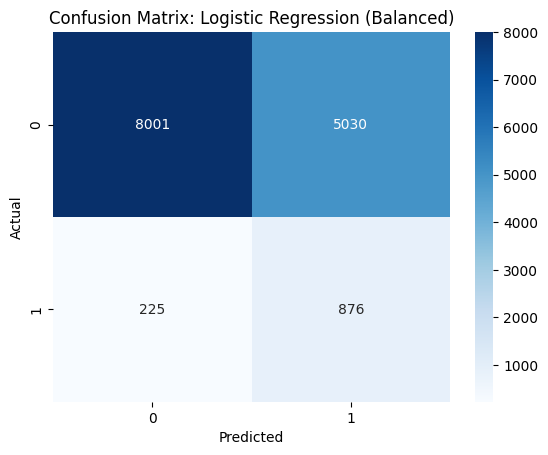

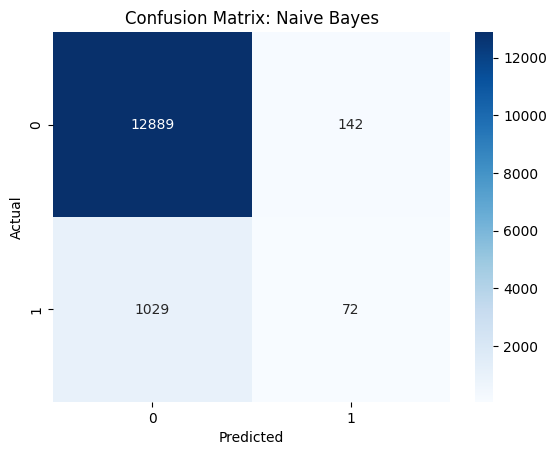

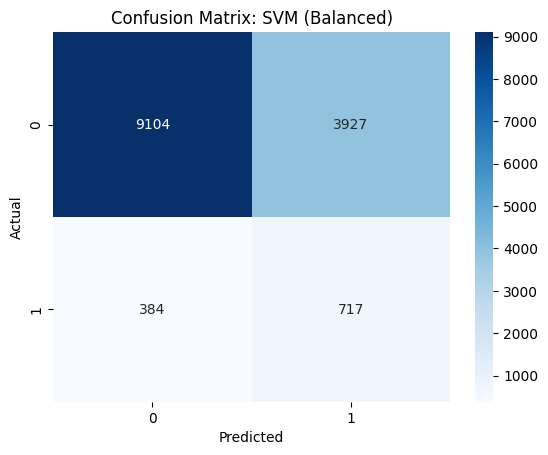

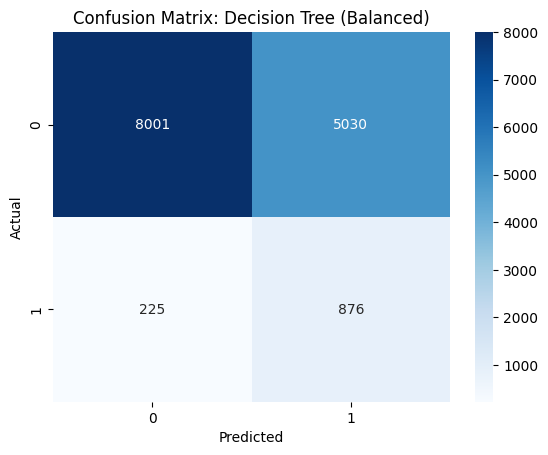

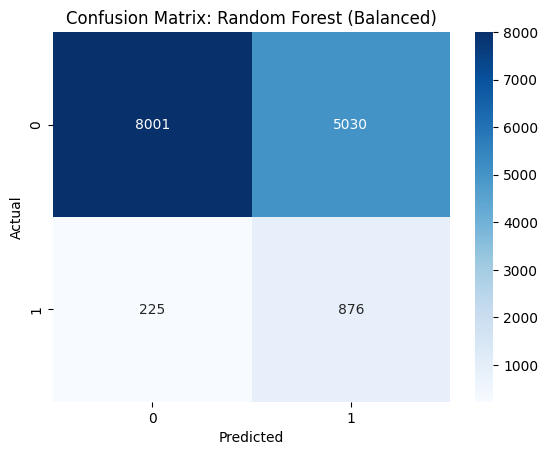

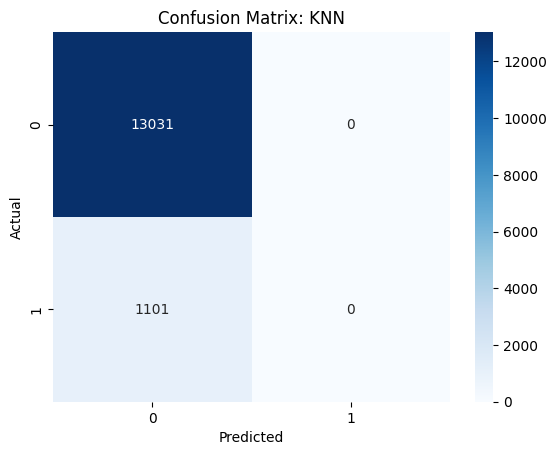

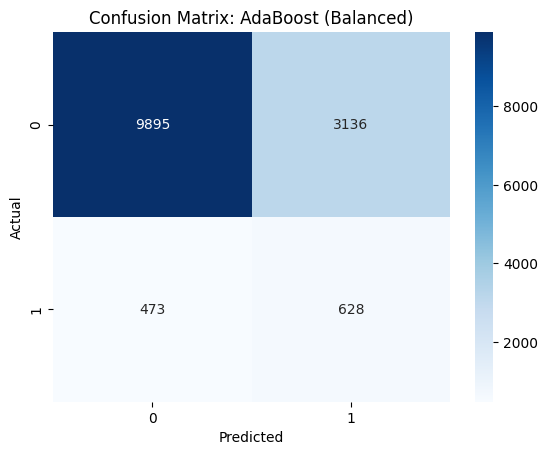

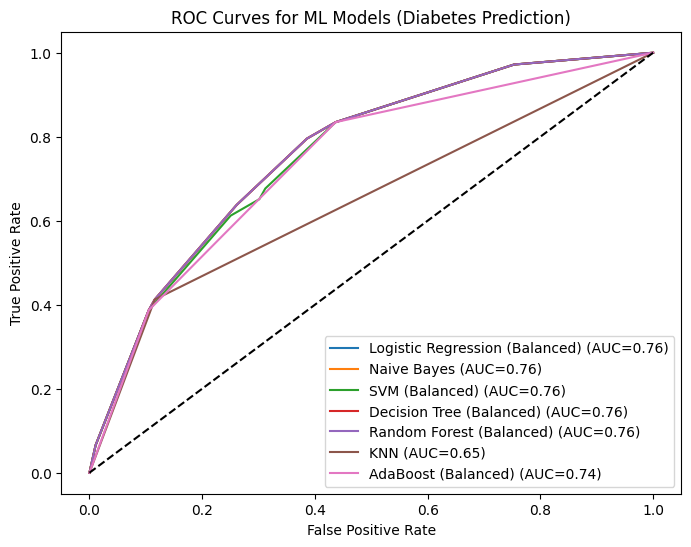

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



 Neural Network Accuracy: 92.21%


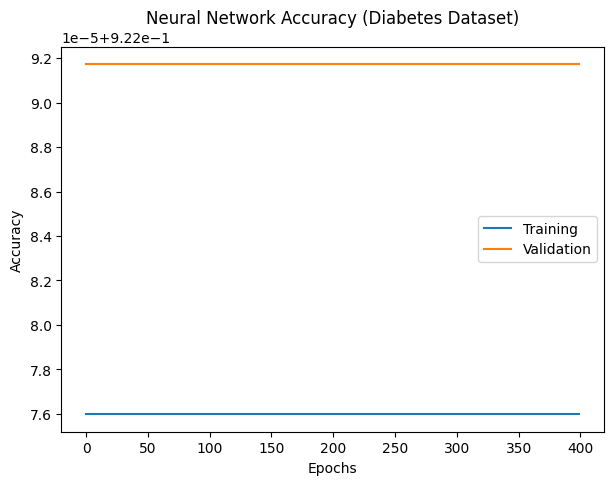

/tmp/ipython-input-3561950130.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="crest")


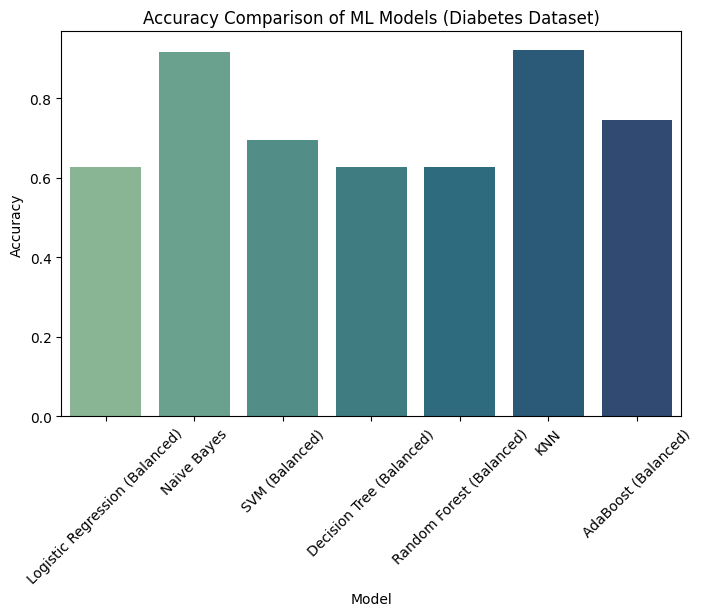

In [ ]:
# Efficient Machine Learning Model for Diabetes Prediction
# Dataset: Kaggle - Diabetes Health Indicators (BRFSS 2015)

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 2. Try Loading the Dataset

print(" Looking for Kaggle file upload...")

try:
    # Preferred: Upload from Kaggle manually (BRFSS 2015 dataset)
    data = pd.read_csv("/content/diabetes_binary_health_indicators_BRFSS2015.csv")
    print(" Loaded local Kaggle dataset successfully.")
except FileNotFoundError:
    # Fallback option if Kaggle file is not uploaded
    print(" Kaggle file not found. Using backup online dataset instead.")
    url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
    data = pd.read_csv(url)

print("Shape:", data.shape)
print("\nDataset Preview:")
display(data.head())

# 3. Data Preprocessing

# If the dataset has 'Diabetes_binary' column (Kaggle BRFSS)
if 'Diabetes_binary' in data.columns:
    y = data['Diabetes_binary']
    X = data.drop(columns=['Diabetes_binary'])
else:
    # fallback dataset target
    y = data['Outcome']
    X = data.drop(columns=['Outcome'])

# Fill missing values if any
X = X.replace([np.inf, -np.inf], np.nan)
X.fillna(X.mean(), inplace=True)

# 4. Outlier Removal (IQR)
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
X = X[mask]
y = y[mask]

print("After removing outliers:", X.shape)

# 5. Feature Selection (Pearson Correlation > 0.2)
corr = pd.concat([X, y], axis=1).corr()['Diabetes_binary' if 'Diabetes_binary' in data.columns else 'Outcome'].abs()
selected_features = corr[corr > 0.2].index.tolist()
if 'Diabetes_binary' in selected_features:
    selected_features.remove('Diabetes_binary')
elif 'Outcome' in selected_features:
    selected_features.remove('Outcome')
print("Selected Features:", selected_features)

X = X[selected_features]

# 6. Normalization
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)

# Insert this import in Step 1
from imblearn.over_sampling import SMOTE

# --- Modify Step 8: ML Models (with Class Weighting) ---

# Note: Not all models support class_weight='balanced'.
# We apply it to those that do (LR, SVM, RF, DT, AdaBoost)
models = {
    "Logistic Regression (Balanced)": LogisticRegression(max_iter=200, class_weight='balanced'),
    "Naive Bayes": GaussianNB(), # Does not support class_weight
    "SVM (Balanced)": SVC(kernel='linear', probability=True, class_weight='balanced'),
    "Decision Tree (Balanced)": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest (Balanced)": RandomForestClassifier(class_weight='balanced'),
    "KNN": KNeighborsClassifier(n_neighbors=7), # Does not support class_weight
    "AdaBoost (Balanced)": AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced')),
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\n Model Performance Summary:\n")
display(results_df)

# 9. Confusion Matrices
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# 10. ROC Curves
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for ML Models (Diabetes Prediction)')
plt.legend()
plt.show()

# 11. Neural Network (2 Hidden Layers, 400 Epochs)
model_nn = Sequential([
    Dense(len(selected_features), input_dim=len(selected_features), activation='relu'),
    Dense(26, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')
])

opt = SGD(learning_rate=0.01)
model_nn.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model_nn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=400, verbose=0)

# 12. ANN Evaluation
loss, acc = model_nn.evaluate(X_test, y_test, verbose=0)
print(f"\n Neural Network Accuracy: {acc*100:.2f}%")

# 13. Plot NN Training Curve
plt.figure(figsize=(7,5))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Neural Network Accuracy (Diabetes Dataset)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# 14. Accuracy Comparison
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="crest")
plt.title("Accuracy Comparison of ML Models (Diabetes Dataset)")
plt.xticks(rotation=45)
plt.show()
